In [1]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [2]:
!pip install scikit-learn==1.3.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 27.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Input
import keras_tuner as kt

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, KFold,train_test_split,GridSearchCV,TimeSeriesSplit
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan,acorr_breusch_godfrey
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from scipy.stats import linregress, pearsonr
from scipy.stats import f,t
import xgboost as xgb

In [4]:
from google.colab import files

uploaded = files.upload()

Saving model_features_daily.csv to model_features_daily.csv


# Valuing Hard Commodities in Dynamic Climate
---
## Part 3: Hard Commodities Valuation Model
- **Period**: May 2024 to November 2024
- **Target Variable**: Copper Futures Price
- **Content**
  1. **Preliminary Analysis**
  2. **Data Preprocessing**
  3. **Multiple Regression Model (Initial Overview)**
      - Raw data used in an unscaled multiple regression to assess data fit without tuning.
  4. **Model Performance Comparison**
      - **4.1 Multiple Regression Model**
      - **4.2 XGBoost**
      - **4.3 LSTM**

In [5]:
pd.options.display.max_columns = 999

In [6]:
df = pd.read_csv('model_features_daily.csv')
df.head()

Date    close_cop  volume_cop  close_alu  volume_alu   close_gold  \
0  2023-12-01  8617.859403        2050    2174.50        20.0  2071.000000   
1  2023-12-04  8422.750483         963    2148.75        20.0  2024.099976   
2  2023-12-05  8316.929034         971    2126.00        20.0  2018.500000   
3  2023-12-06  8193.470327         551    2109.75        20.0  2030.500000   
4  2023-12-07  8343.384133         721    2092.50        35.0  2029.900024   

   volume_gold  close_wti  volume_wti  close_ng  volume_ng       close_b  \
0        614.0  74.070000    358976.0     2.814     133190  38688.750000   
1       1071.0  73.040001    388832.0     2.694     161786  41980.097656   
2        289.0  72.320000    358703.0     2.710     119974  44080.648438   
3        417.0  69.379997    436803.0     2.569     218374  43746.445312   
4         67.0  69.339996    339000.0     2.585     248396  43292.664062   

      volume_b    close_eth   volume_eth    vix   usdEUR  ele_total    ele_ng  \
0  23512784002  2087.139893  10866891430  12.63  0.91810   54235932  23442631   
1  39856129827  2243.215820  16149367134  13.08  0.91843   53753188  23089546   
2  36312154535  2293.841797  15383072559  12.85  0.92270   55043618  24100581   
3  29909761586  2231.661377  12790612571  12.97  0.92647   55980891  22593816   
4  27635760671  2357.579590  14766891042  13.06  0.92879   56379352  20830353   

   ele_oil  ele_demand  ele_ic  
0    43313    54439236  163609  
1    43611    54059830   57634  
2    46291    55294658   51512  
3    47211    56212967   20743  
4    45043    56739527   34465

In [7]:
df = df[(df['Date'] >= '2024-05-01')&(df['Date'] <= '2024-11-30')].reset_index(drop=True)
df

Date     close_cop  volume_cop  close_alu  volume_alu   close_gold  \
0    2024-05-01  10036.532045        1659    2537.75         0.0  2299.899902   
1    2024-05-02   9907.562187         864    2491.75         0.0  2299.199951   
2    2024-05-03  10082.829915         879    2512.25         0.0  2299.000000   
3    2024-05-06  10217.311449         642    2554.25         0.0  2321.600098   
4    2024-05-07  10197.470256         823    2527.00         1.0  2315.199951   
..          ...           ...         ...        ...         ...          ...   
143  2024-11-22   8981.621619         514    2556.00         0.0  2709.899902   
144  2024-11-25   9020.202301         335    2580.75         0.0  2616.800049   
145  2024-11-26   8904.460256       37274    2555.25        14.0  2620.300049   
146  2024-11-27   8966.189347       11425    2556.50         0.0  2639.899902   
147  2024-11-29   8995.952188        1274    2562.00        12.0  2657.000000   

     volume_gold  close_wti  volume_wti  close_ng  volume_ng       close_b  \
0           42.0  79.000000    441978.0     1.932     135918  58254.011719   
1           56.0  78.949997    359652.0     2.035     153739  59123.433594   
2          194.0  78.110001    324438.0     2.142     209456  62889.835938   
3            9.0  78.480003    297369.0     2.195     196381  63161.949219   
4           25.0  78.379997    327593.0     2.207     149430  62334.816406   
..           ...        ...         ...       ...        ...           ...   
143         41.0  71.239998    408207.0     3.129      95807  98997.664062   
144         94.0  68.940002    380922.0     3.369     108485  93102.296875   
145     177858.0  68.769997    292138.0     3.431     222049  91985.320312   
146      61653.0  68.720001    227215.0     3.204     214291  95962.531250   
147       3861.0  68.000000    291408.0     3.363     163060  97461.523438   

        volume_b    close_eth   volume_eth    vix   usdEUR  ele_total  \
0    48439780271  2969.784668  20005057445  15.39  0.93751   53785516   
1    32711813559  2988.168457  13163903903  14.68  0.93270   54281449   
2    33172023048  3103.541992  12862183229  13.49  0.93170   52849224   
3    28697928697  3062.728760  13008587255  13.49  0.92953   53736558   
4    25930730982  3006.577148  11743187337  13.23  0.92872   55390304   
..           ...          ...          ...    ...      ...        ...   
143  78473580551  3331.600830  36775716442  15.24  0.95517   54269455   
144  80909462490  3413.543945  51544793988  14.60  0.95421   53164839   
145  91656519855  3326.517334  39902959158  14.10  0.95746   53547581   
146  71133452438  3657.249268  43383987191  14.10  0.95318   53727082   
147  54968682476  3593.494385  27622629486  13.51  0.94670   53594022   

       ele_ng  ele_oil  ele_demand  ele_ic  
0    21637669   112706    53993863  184028  
1    23096113   193433    54521367    7610  
2    22425534   136459    52904435  164868  
3    20512576    59625    53631124  368525  
4    22049630   111337    55289245  322964  
..        ...      ...         ...     ...  
143  23006123    58587    54833279  -38678  
144  20892742    39157    53395204  138806  
145  22079097    44352    53707621  101987  
146  20827169    39884    54167161  119126  
147  20851570    37676    53997391    2415  

[148 rows x 22 columns]

## 1. Preliminary Analysis
---
- **Scatter Plot Matrix**
- **Correlation Analysis**


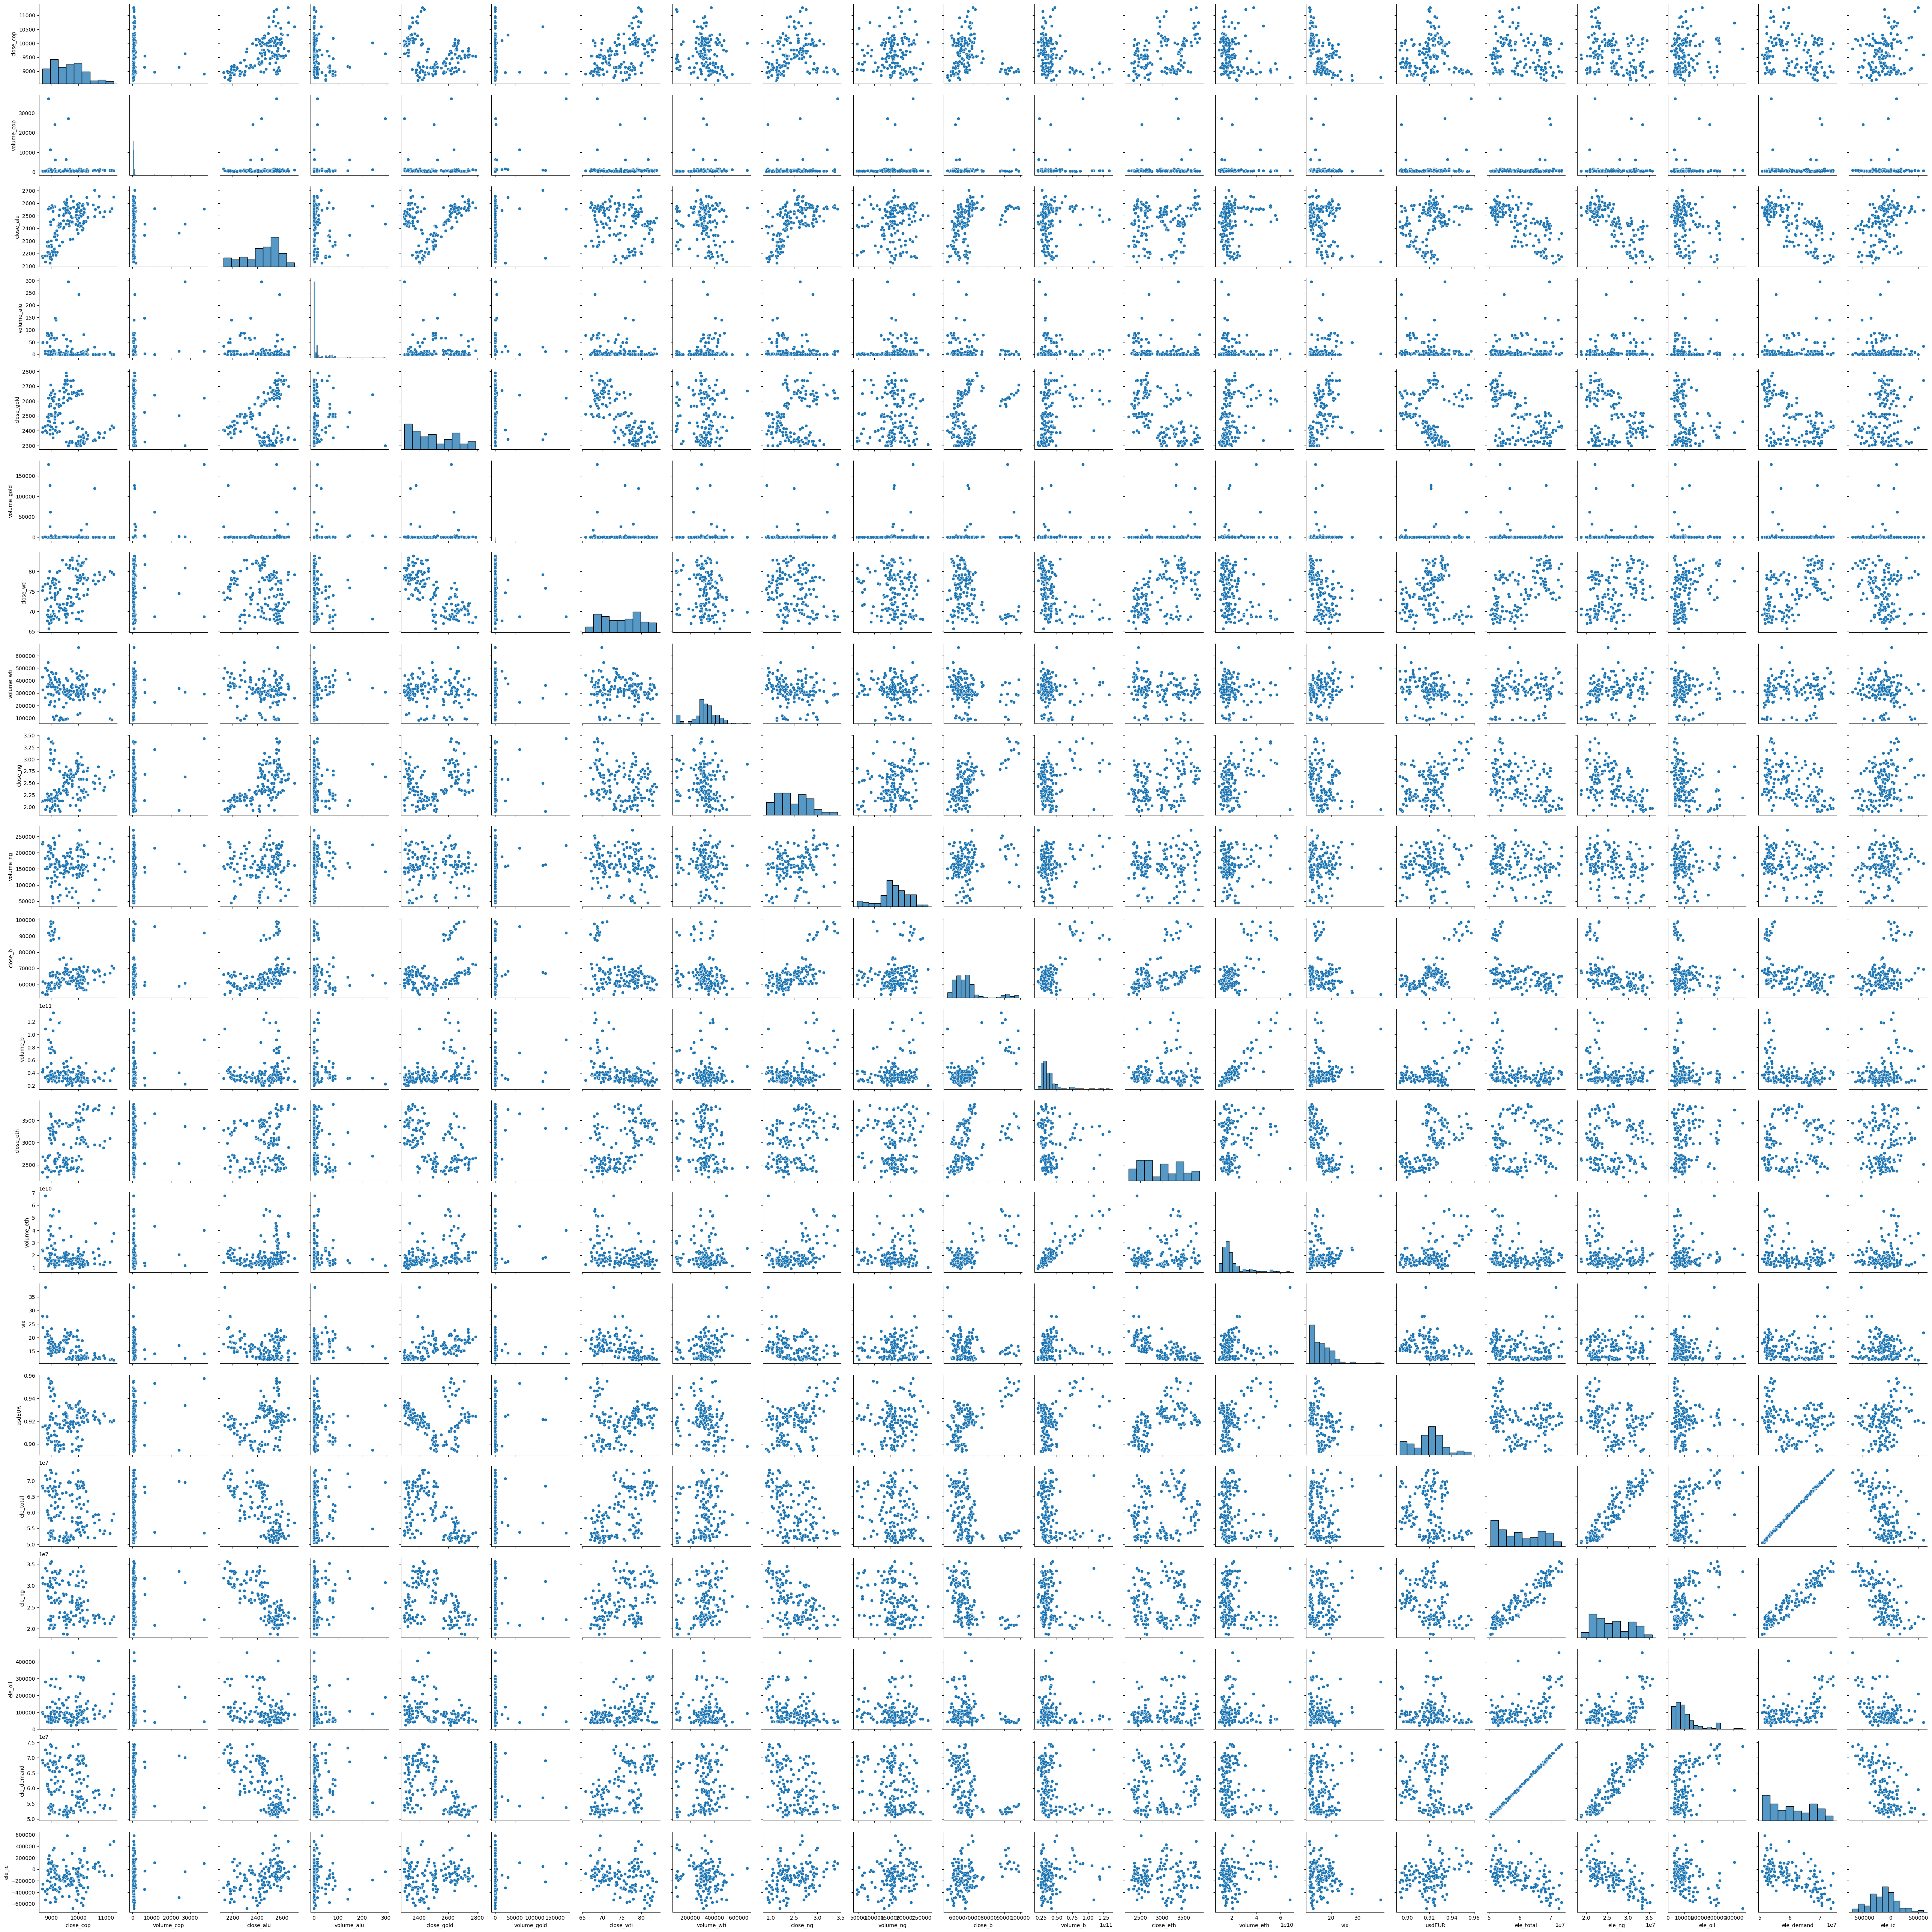

In [ ]:
# Scatterplot Matrix (with all features)
sns.pairplot(df)
plt.show()

In [8]:
# Correlation Table
correlation_matrix = df.drop(columns=['Date']).corr()
correlation_matrix

close_cop  volume_cop  close_alu  volume_alu  close_gold  \
close_cop     1.000000   -0.114539   0.593136   -0.192247   -0.338596   
volume_cop   -0.114539    1.000000   0.034854    0.313887   -0.008546   
close_alu     0.593136    0.034854   1.000000   -0.175514    0.312465   
volume_alu   -0.192247    0.313887  -0.175514    1.000000    0.019944   
close_gold   -0.338596   -0.008546   0.312465    0.019944    1.000000   
volume_gold  -0.071214    0.524914   0.051000    0.009910   -0.011327   
close_wti     0.476649   -0.024161  -0.173510   -0.169760   -0.767413   
volume_wti   -0.117578   -0.009807  -0.161209    0.150809   -0.014146   
close_ng      0.219994    0.140952   0.631540   -0.086067    0.266974   
volume_ng     0.010424    0.077718   0.087759    0.124504    0.022599   
close_b      -0.136355    0.137220   0.429082   -0.130791    0.356281   
volume_b     -0.338758    0.110682   0.124977   -0.069916    0.362977   
close_eth     0.403985    0.080753   0.184344   -0.139388   -0.584287   
volume_eth   -0.226650    0.095203   0.114382   -0.094409    0.265017   
vix          -0.528285   -0.096937  -0.307586    0.110896    0.456339   
usdEUR        0.073107    0.173801   0.293754   -0.178642   -0.152730   
ele_total    -0.174194    0.057388  -0.712317    0.133247   -0.570096   
ele_ng       -0.315542    0.036052  -0.786223    0.174518   -0.386538   
ele_oil       0.174060    0.044891  -0.249332    0.012783   -0.301224   
ele_demand   -0.184843    0.054319  -0.717829    0.134204   -0.556701   
ele_ic        0.165328    0.032622   0.438829   -0.080418    0.171462   

             volume_gold  close_wti  volume_wti  close_ng  volume_ng  \
close_cop      -0.071214   0.476649   -0.117578  0.219994   0.010424   
volume_cop      0.524914  -0.024161   -0.009807  0.140952   0.077718   
close_alu       0.051000  -0.173510   -0.161209  0.631540   0.087759   
volume_alu      0.009910  -0.169760    0.150809 -0.086067   0.124504   
close_gold     -0.011327  -0.767413   -0.014146  0.266974   0.022599   
volume_gold     1.000000  -0.059586   -0.013314  0.126022   0.105844   
close_wti      -0.059586   1.000000   -0.119540 -0.257832  -0.164513   
volume_wti     -0.013314  -0.119540    1.000000 -0.113079  -0.067831   
close_ng        0.126022  -0.257832   -0.113079  1.000000   0.271338   
volume_ng       0.105844  -0.164513   -0.067831  0.271338   1.000000   
close_b         0.220309  -0.393864   -0.222848  0.678503   0.211314   
volume_b        0.131163  -0.451537   -0.008552  0.387921   0.215731   
close_eth       0.188568   0.498001   -0.170281  0.329655   0.042053   
volume_eth      0.123584  -0.337480    0.027893  0.400638   0.115910   
vix            -0.063719  -0.463391    0.279835 -0.256066   0.018123   
usdEUR          0.200377   0.146868   -0.234462  0.469459   0.139962   
ele_total      -0.034101   0.567647    0.108274 -0.463582  -0.207840   
ele_ng         -0.069102   0.411300    0.220051 -0.551075  -0.225524   
ele_oil        -0.066748   0.400127   -0.001783 -0.316878  -0.063842   
ele_demand     -0.036828   0.560055    0.113040 -0.465515  -0.209954   
ele_ic          0.084479  -0.261514   -0.162065  0.281853   0.229131   

              close_b  volume_b  close_eth  volume_eth       vix    usdEUR  \
close_cop   -0.136355 -0.338758   0.403985   -0.226650 -0.528285  0.073107   
volume_cop   0.137220  0.110682   0.080753    0.095203 -0.096937  0.173801   
close_alu    0.429082  0.124977   0.184344    0.114382 -0.307586  0.293754   
volume_alu  -0.130791 -0.069916  -0.139388   -0.094409  0.110896 -0.178642   
close_gold   0.356281  0.362977  -0.584287    0.265017  0.456339 -0.152730   
volume_gold  0.220309  0.131163   0.188568    0.123584 -0.063719  0.200377   
close_wti   -0.393864 -0.451537   0.498001   -0.337480 -0.463391  0.146868   
volume_wti  -0.222848 -0.008552  -0.170281    0.027893  0.279835 -0.234462   
close_ng     0.678503  0.387921   0.329655    0.400638 -0.256066  0.469459   
volume_ng    0.211314  0.215731   0.04205

In [9]:
def find_high_corr(correlation_matrix, threshold=0.6):

    high_corr_pairs = []

    for i in range(len(correlation_matrix.columns)):
        for j in range(i + 1, len(correlation_matrix.columns)):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > threshold:
                high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_value))

    if high_corr_pairs:
        print(f"Highly correlated variable pairs (|correlation| > {threshold}):")
        for var1, var2, corr in high_corr_pairs:
            print(f"{var1} and {var2}: {corr:.3f}")
    else:
        print(f"No pairs found with |correlation| > {threshold}.")

In [10]:
# Find pairs with high correlation (absolute value > 0.6)
find_high_corr(correlation_matrix, threshold=0.6)

Highly correlated variable pairs (|correlation| > 0.6):
close_alu and close_ng: 0.632
close_alu and ele_total: -0.712
close_alu and ele_ng: -0.786
close_alu and ele_demand: -0.718
close_gold and close_wti: -0.767
close_ng and close_b: 0.679
close_b and volume_b: 0.689
close_b and volume_eth: 0.633
close_b and usdEUR: 0.670
volume_b and volume_eth: 0.909
close_eth and vix: -0.670
ele_total and ele_ng: 0.931
ele_total and ele_demand: 0.999
ele_total and ele_ic: -0.605
ele_ng and ele_demand: 0.938
ele_ng and ele_ic: -0.690
ele_demand and ele_ic: -0.619


In [11]:
df.columns

Index(['Date', 'close_cop', 'volume_cop', 'close_alu', 'volume_alu',
       'close_gold', 'volume_gold', 'close_wti', 'volume_wti', 'close_ng',
       'volume_ng', 'close_b', 'volume_b', 'close_eth', 'volume_eth', 'vix',
       'usdEUR', 'ele_total', 'ele_ng', 'ele_oil', 'ele_demand', 'ele_ic'],
      dtype='object')

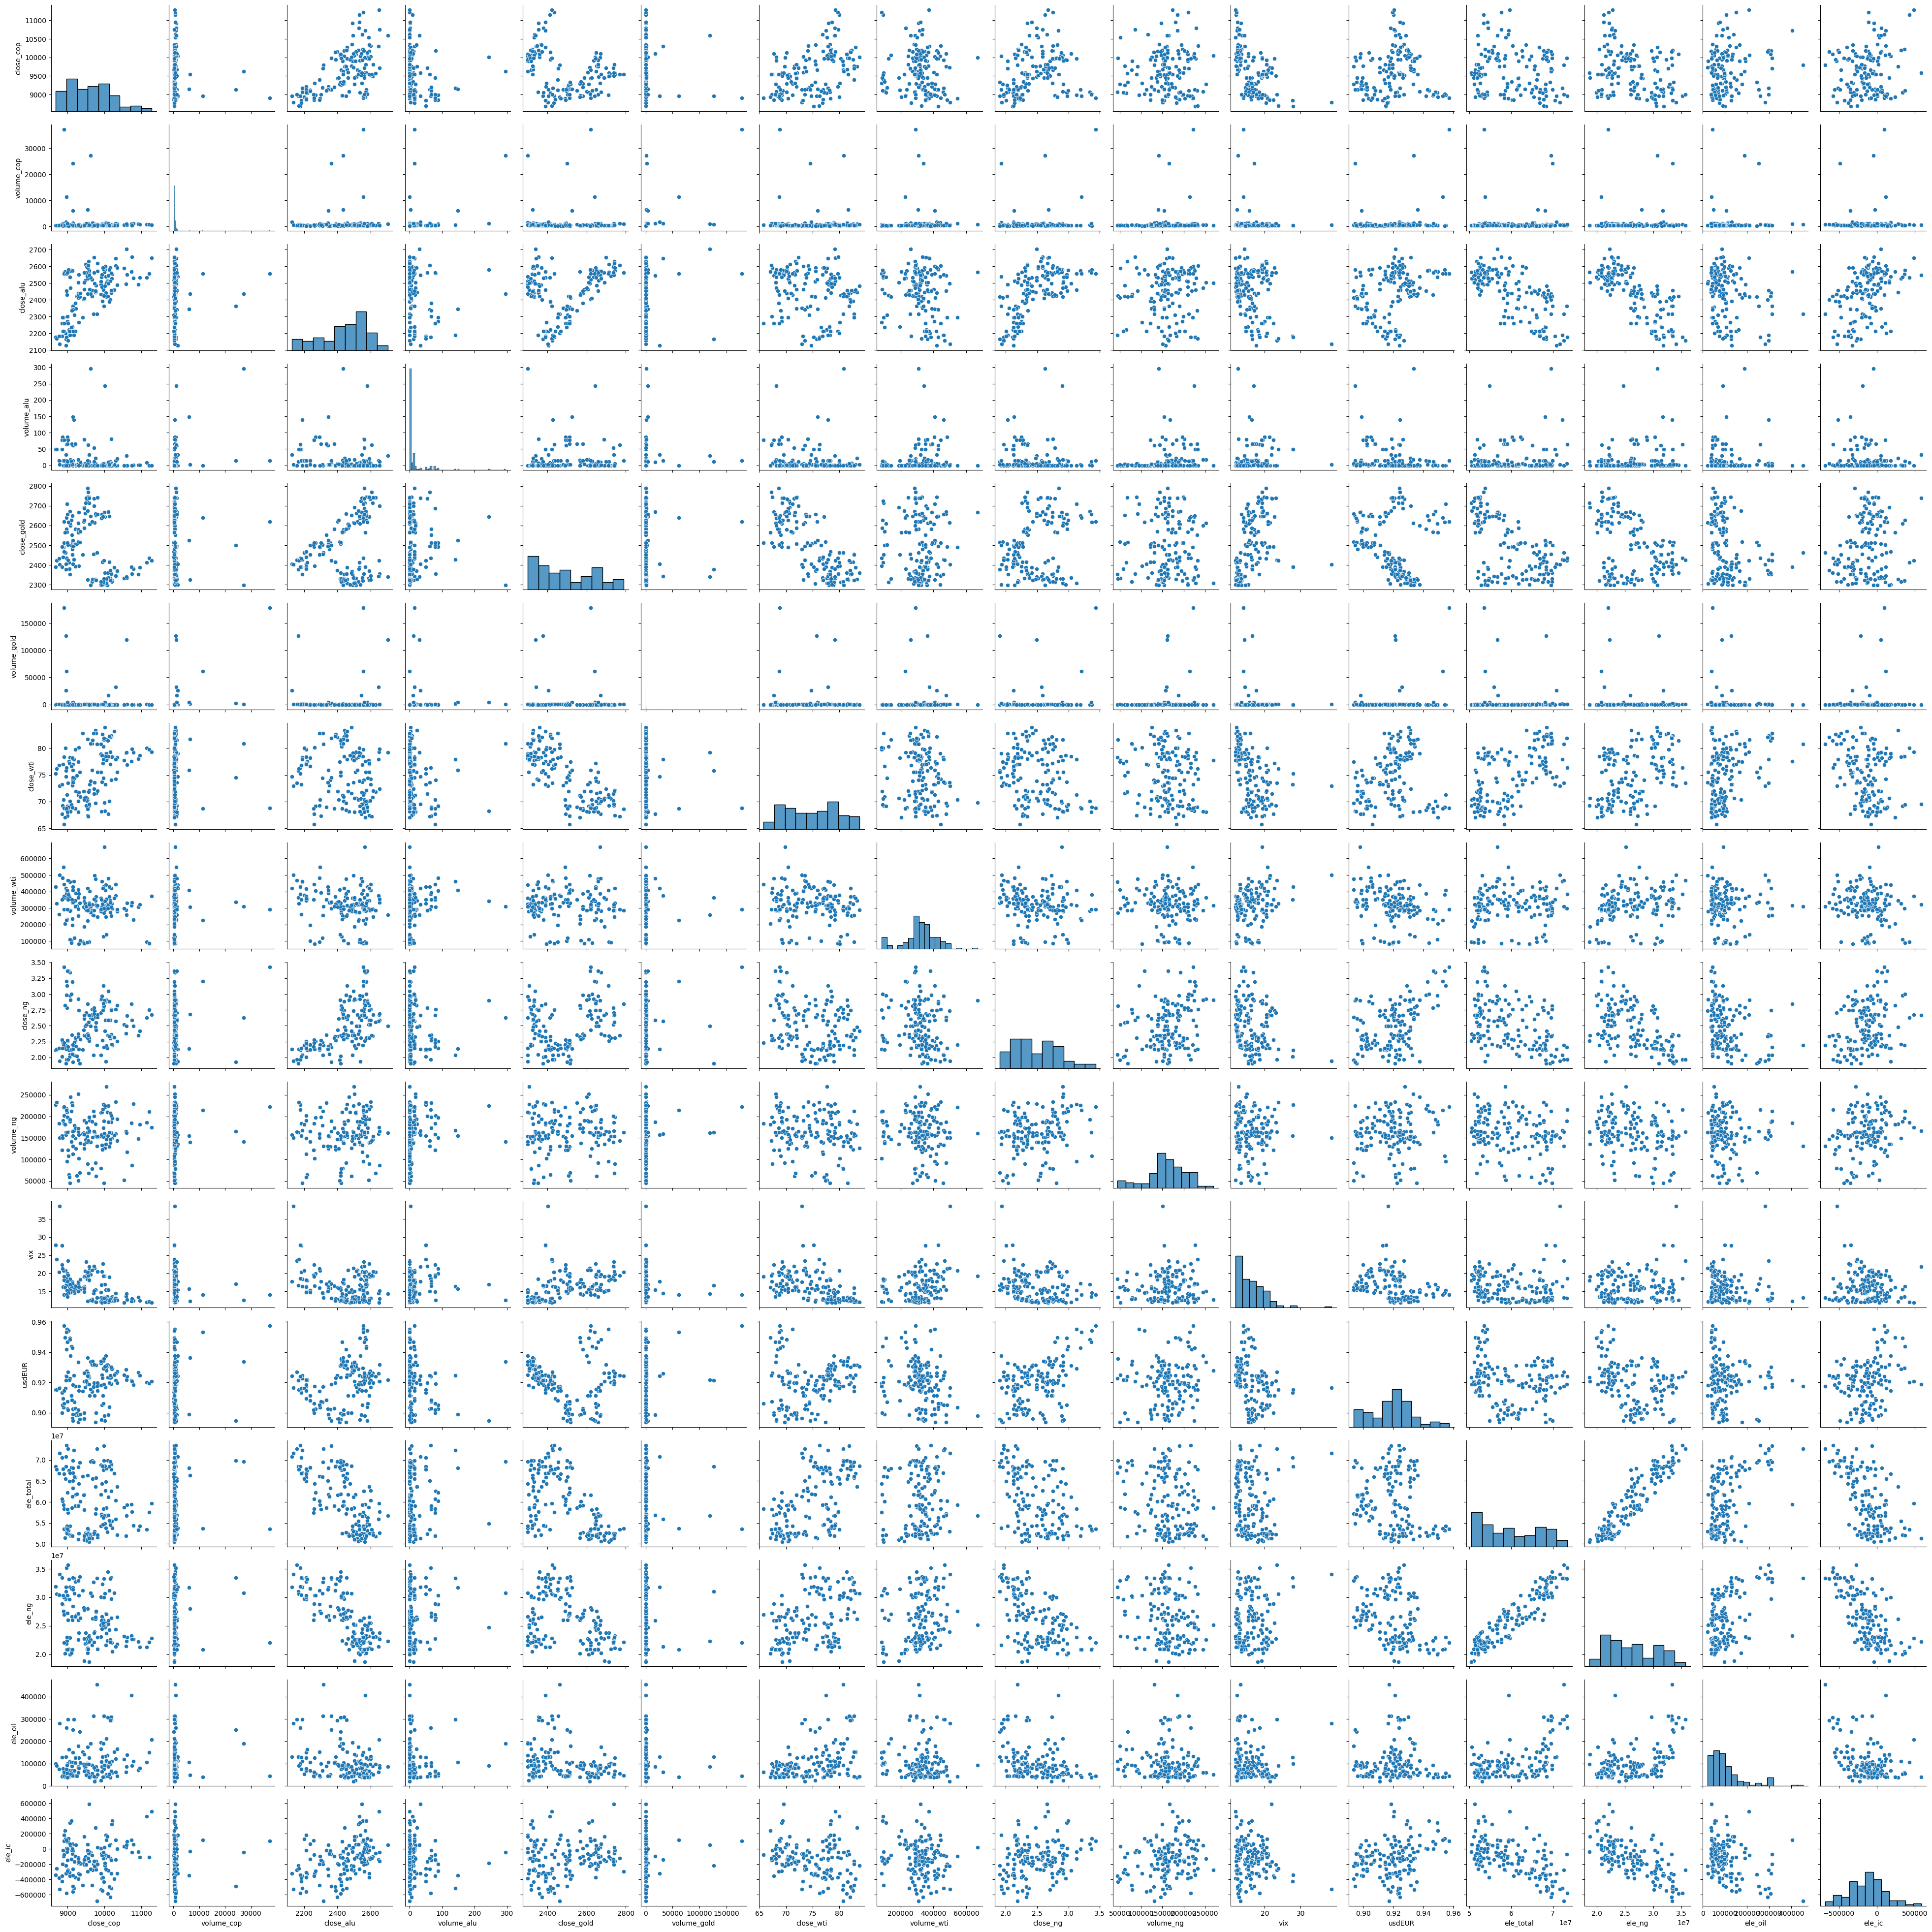

In [12]:
df_filtered = df.drop(columns=['close_b','close_eth','volume_b','volume_eth','ele_demand'])

# Scatterplot Matrix (with filtered features)
sns.pairplot(df_filtered)
plt.show()

In [13]:
# Correlation Table
correlation_matrix2 = df_filtered.drop(columns=['Date']).corr()
correlation_matrix2

close_cop  volume_cop  close_alu  volume_alu  close_gold  \
close_cop     1.000000   -0.114539   0.593136   -0.192247   -0.338596   
volume_cop   -0.114539    1.000000   0.034854    0.313887   -0.008546   
close_alu     0.593136    0.034854   1.000000   -0.175514    0.312465   
volume_alu   -0.192247    0.313887  -0.175514    1.000000    0.019944   
close_gold   -0.338596   -0.008546   0.312465    0.019944    1.000000   
volume_gold  -0.071214    0.524914   0.051000    0.009910   -0.011327   
close_wti     0.476649   -0.024161  -0.173510   -0.169760   -0.767413   
volume_wti   -0.117578   -0.009807  -0.161209    0.150809   -0.014146   
close_ng      0.219994    0.140952   0.631540   -0.086067    0.266974   
volume_ng     0.010424    0.077718   0.087759    0.124504    0.022599   
vix          -0.528285   -0.096937  -0.307586    0.110896    0.456339   
usdEUR        0.073107    0.173801   0.293754   -0.178642   -0.152730   
ele_total    -0.174194    0.057388  -0.712317    0.133247   -0.570096   
ele_ng       -0.315542    0.036052  -0.786223    0.174518   -0.386538   
ele_oil       0.174060    0.044891  -0.249332    0.012783   -0.301224   
ele_ic        0.165328    0.032622   0.438829   -0.080418    0.171462   

             volume_gold  close_wti  volume_wti  close_ng  volume_ng  \
close_cop      -0.071214   0.476649   -0.117578  0.219994   0.010424   
volume_cop      0.524914  -0.024161   -0.009807  0.140952   0.077718   
close_alu       0.051000  -0.173510   -0.161209  0.631540   0.087759   
volume_alu      0.009910  -0.169760    0.150809 -0.086067   0.124504   
close_gold     -0.011327  -0.767413   -0.014146  0.266974   0.022599   
volume_gold     1.000000  -0.059586   -0.013314  0.126022   0.105844   
close_wti      -0.059586   1.000000   -0.119540 -0.257832  -0.164513   
volume_wti     -0.013314  -0.119540    1.000000 -0.113079  -0.067831   
close_ng        0.126022  -0.257832   -0.113079  1.000000   0.271338   
volume_ng       0.105844  -0.164513   -0.067831  0.271338   1.000000   
vix            -0.063719  -0.463391    0.279835 -0.256066   0.018123   
usdEUR          0.200377   0.146868   -0.234462  0.469459   0.139962   
ele_total      -0.034101   0.567647    0.108274 -0.463582  -0.207840   
ele_ng         -0.069102   0.411300    0.220051 -0.551075  -0.225524   
ele_oil        -0.066748   0.400127   -0.001783 -0.316878  -0.063842   
ele_ic          0.084479  -0.261514   -0.162065  0.281853   0.229131   

                  vix    usdEUR  ele_total    ele_ng   ele_oil    ele_ic  
close_cop   -0.528285  0.073107  -0.174194 -0.315542  0.174060  0.165328  
volume_cop  -0.096937  0.173801   0.057388  0.036052  0.044891  0.032622  
close_alu   -0.307586  0.293754  -0.712317 -0.786223 -0.249332  0.438829  
volume_alu   0.110896 -0.178642   0.133247  0.174518  0.012783 -0.080418  
close_gold   0.456339 -0.152730  -0.570096 -0.386538 -0.301224  0.171462  
volume_gold -0.063719  0.200377  -0.034101 -0.069102 -0.066748  0.084479  
close_wti   -0.463391  0.146868   0.567647  0.411300  0.400127 -0.261514  
volume_wti   0.279835 -0.234462   0.108274  0.220051 -0.001783 -0.162065  
close_ng    -0.256066  0.469459  -0.463582 -0.551075 -0.316878  0.281853  
volume_ng    0.018123  0.139962  -0.207840 -0.225524 -0.063842  0.229131  
vix          1.000000 -0.314789  -0.072271  0.096791 -0.103421 -0.123586  
usdEUR      -0.314789  1.000000  -0.206103 -0.363641 -0.023447  0.247617  
ele_total   -0.072271 -0.206103   1.000000  0.931232  0.537021 -0.604790  
ele_ng       0.096791 -0.363641   0.931232  1.000000  0.495524 -0.689933  
ele_oil     -0.103421 -0.023447   0.537021  0.495524  1.000000 -0.367105  
ele_ic      -0.123586  0.247617  -0.604790 -0.689933 -0.367105  1.000000

In [14]:
# Find pairs with high correlation (absolute value > 0.6)
find_high_corr(correlation_matrix2, threshold=0.6)

Highly correlated variable pairs (|correlation| > 0.6):
close_alu and close_ng: 0.632
close_alu and ele_total: -0.712
close_alu and ele_ng: -0.786
close_gold and close_wti: -0.767
ele_total and ele_ng: 0.931
ele_total and ele_ic: -0.605
ele_ng and ele_ic: -0.690


## 2. Data Preprocessing
---
- Extract time-related variables from “date”
- Features Selection
- Data splitting and scaling

### Time-related variables

In [15]:
df_filtered[['year', 'month','day']] = df_filtered['Date'].str.split('-',expand=True)

df_filtered.head()

Date     close_cop  volume_cop  close_alu  volume_alu   close_gold  \
0  2024-05-01  10036.532045        1659    2537.75         0.0  2299.899902   
1  2024-05-02   9907.562187         864    2491.75         0.0  2299.199951   
2  2024-05-03  10082.829915         879    2512.25         0.0  2299.000000   
3  2024-05-06  10217.311449         642    2554.25         0.0  2321.600098   
4  2024-05-07  10197.470256         823    2527.00         1.0  2315.199951   

   volume_gold  close_wti  volume_wti  close_ng  volume_ng    vix   usdEUR  \
0         42.0  79.000000    441978.0     1.932     135918  15.39  0.93751   
1         56.0  78.949997    359652.0     2.035     153739  14.68  0.93270   
2        194.0  78.110001    324438.0     2.142     209456  13.49  0.93170   
3          9.0  78.480003    297369.0     2.195     196381  13.49  0.92953   
4         25.0  78.379997    327593.0     2.207     149430  13.23  0.92872   

   ele_total    ele_ng  ele_oil  ele_ic  year month day  
0   53785516  21637669   112706  184028  2024    05  01  
1   54281449  23096113   193433    7610  2024    05  02  
2   52849224  22425534   136459  164868  2024    05  03  
3   53736558  20512576    59625  368525  2024    05  06  
4   55390304  22049630   111337  322964  2024    05  07

In [16]:
df_filtered[['year', 'month','day']] = df_filtered[['year', 'month','day']].astype('int')
df_model = df_filtered.drop('Date', axis=1)
df_model.head()

close_cop  volume_cop  close_alu  volume_alu   close_gold  volume_gold  \
0  10036.532045        1659    2537.75         0.0  2299.899902         42.0   
1   9907.562187         864    2491.75         0.0  2299.199951         56.0   
2  10082.829915         879    2512.25         0.0  2299.000000        194.0   
3  10217.311449         642    2554.25         0.0  2321.600098          9.0   
4  10197.470256         823    2527.00         1.0  2315.199951         25.0   

   close_wti  volume_wti  close_ng  volume_ng    vix   usdEUR  ele_total  \
0  79.000000    441978.0     1.932     135918  15.39  0.93751   53785516   
1  78.949997    359652.0     2.035     153739  14.68  0.93270   54281449   
2  78.110001    324438.0     2.142     209456  13.49  0.93170   52849224   
3  78.480003    297369.0     2.195     196381  13.49  0.92953   53736558   
4  78.379997    327593.0     2.207     149430  13.23  0.92872   55390304   

     ele_ng  ele_oil  ele_ic  year  month  day  
0  21637669   112706  184028  2024      5    1  
1  23096113   193433    7610  2024      5    2  
2  22425534   136459  164868  2024      5    3  
3  20512576    59625  368525  2024      5    6  
4  22049630   111337  322964  2024      5    7

In [17]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   close_cop    148 non-null    float64
 1   volume_cop   148 non-null    int64  
 2   close_alu    148 non-null    float64
 3   volume_alu   148 non-null    float64
 4   close_gold   148 non-null    float64
 5   volume_gold  148 non-null    float64
 6   close_wti    148 non-null    float64
 7   volume_wti   148 non-null    float64
 8   close_ng     148 non-null    float64
 9   volume_ng    148 non-null    int64  
 10  vix          148 non-null    float64
 11  usdEUR       148 non-null    float64
 12  ele_total    148 non-null    int64  
 13  ele_ng       148 non-null    int64  
 14  ele_oil      148 non-null    int64  
 15  ele_ic       148 non-null    int64  
 16  year         148 non-null    int64  
 17  month        148 non-null    int64  
 18  day          148 non-null    int64  
dtypes: float

In [18]:
df_model.columns

Index(['close_cop', 'volume_cop', 'close_alu', 'volume_alu', 'close_gold',
       'volume_gold', 'close_wti', 'volume_wti', 'close_ng', 'volume_ng',
       'vix', 'usdEUR', 'ele_total', 'ele_ng', 'ele_oil', 'ele_ic', 'year',
       'month', 'day'],
      dtype='object')

### Features Selection

In [19]:
features = ['volume_cop', 'close_alu', 'volume_alu', 'close_gold',
       'volume_gold','vix', 'usdEUR', 'ele_ic','month', 'day']

X = df_model[features]
y = df_model["close_cop"]

### Data Splitting & Scaling

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle = False)

In [21]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features)

## 3. Multiple Regression Model (Initial Overview)
---
- **Models**
	1. With “year, month, day” variables
	2. Without time-related variables
- **Note**
  - Feature Selection (Consistent with  *2. Data Processing*)


In [ ]:
formula1 = 'close_cop ~ volume_cop + close_alu + volume_alu + close_gold + volume_gold + vix + usdEUR + ele_ic'

model1 = ols(formula1, data=df_model).fit()

print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:              close_cop   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     50.85
Date:                Sun, 02 Feb 2025   Prob (F-statistic):           1.33e-37
Time:                        20:21:57   Log-Likelihood:                -1048.8
No. Observations:                 148   AIC:                             2116.
Df Residuals:                     139   BIC:                             2143.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.735e+04   1913.101      9.069      

In [ ]:
formula2 = 'close_cop ~ volume_cop + close_alu + volume_alu + close_gold + volume_gold + vix + usdEUR + ele_ic + year + month + day'

model2 = ols(formula2, data=df_model).fit()

print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:              close_cop   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     98.42
Date:                Sun, 02 Feb 2025   Prob (F-statistic):           1.83e-57
Time:                        20:48:58   Log-Likelihood:                -994.47
No. Observations:                 148   AIC:                             2011.
Df Residuals:                     137   BIC:                             2044.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0003      0.000      0.699      

## 4. Model Performance Comparison
---
- **4.1 Multiple Regression Model**
    - **4.1.1** Assumption Checks
    - **4.1.2** Influence Analysis
    - **4.1.3** Cleaned model (excluding influential points based on studentized residuals)
- **4.2 XGBoost**
    - **Model 1**: Hyperparameter tuning to identify optimal model
    - **Model 2**: No hyperparameter tuning
    - **Model 3**: Self-adjusted hyperparameters
- **4.3 LSTM**

### 4.1 Multiple Regression Model

In [ ]:
X_train_scaled_df = sm.add_constant(X_train_scaled_df)

X_test_scaled_df['const'] = 1
X_test_scaled_df = X_test_scaled_df[['const'] + list(X_test_scaled_df.columns[:-1])]

In [ ]:
y_train_reset = y_train.reset_index(drop=True)
X_train_scaled_df_reset = X_train_scaled_df.reset_index(drop=True)

In [ ]:
regression_model = sm.OLS(y_train_reset, X_train_scaled_df_reset).fit()

In [ ]:
y_pred_reg = regression_model.predict(X_test_scaled_df)

In [ ]:
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_reg))
print(f'Test RMSE: {test_rmse:.4f}')

Test RMSE: 408.8725


In [ ]:
print(regression_model.summary())

                            OLS Regression Results                            
Dep. Variable:              close_cop   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     89.26
Date:                Sun, 02 Feb 2025   Prob (F-statistic):           6.91e-43
Time:                        20:22:56   Log-Likelihood:                -689.32
No. Observations:                 103   AIC:                             1401.
Df Residuals:                      92   BIC:                             1430.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        9543.2285    246.614     38.697      

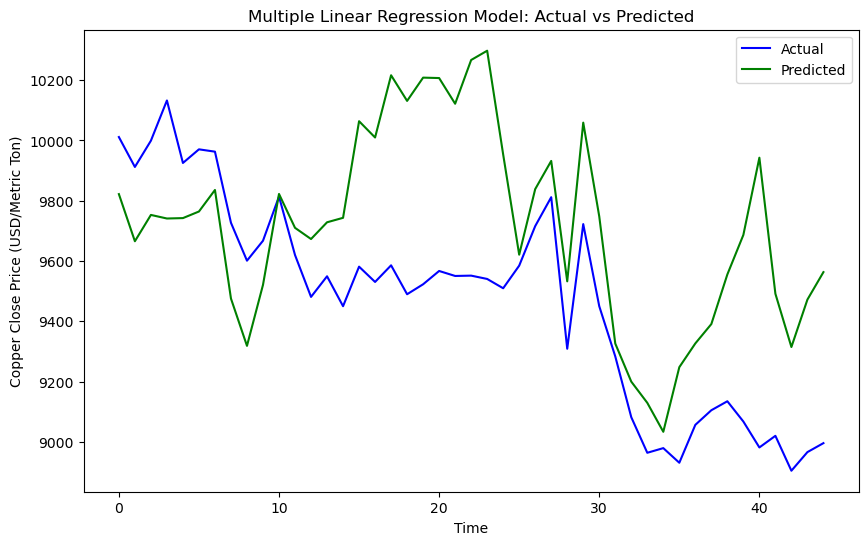

In [ ]:
y_test_reset = y_test.reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.plot(y_test_reset, label='Actual', color='blue')
plt.plot(y_pred_reg, label='Predicted', color='green')
plt.title('Multiple Linear Regression Model: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Copper Close Price (USD/Metric Ton)')
plt.legend()
plt.show()

### 4.1.1 Assumption Checks
---
- **Normality**: 
    - Q-Q Plot / Residual Analysis
- **Homoskedasticity**
    - Breusch-Pagan (BP) Test
- **Serial Correlation**
    - Breusch-Godfrey (BG) Test
- **Multicollinearity**
    - Variance Inflation Factor (VIF)


eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


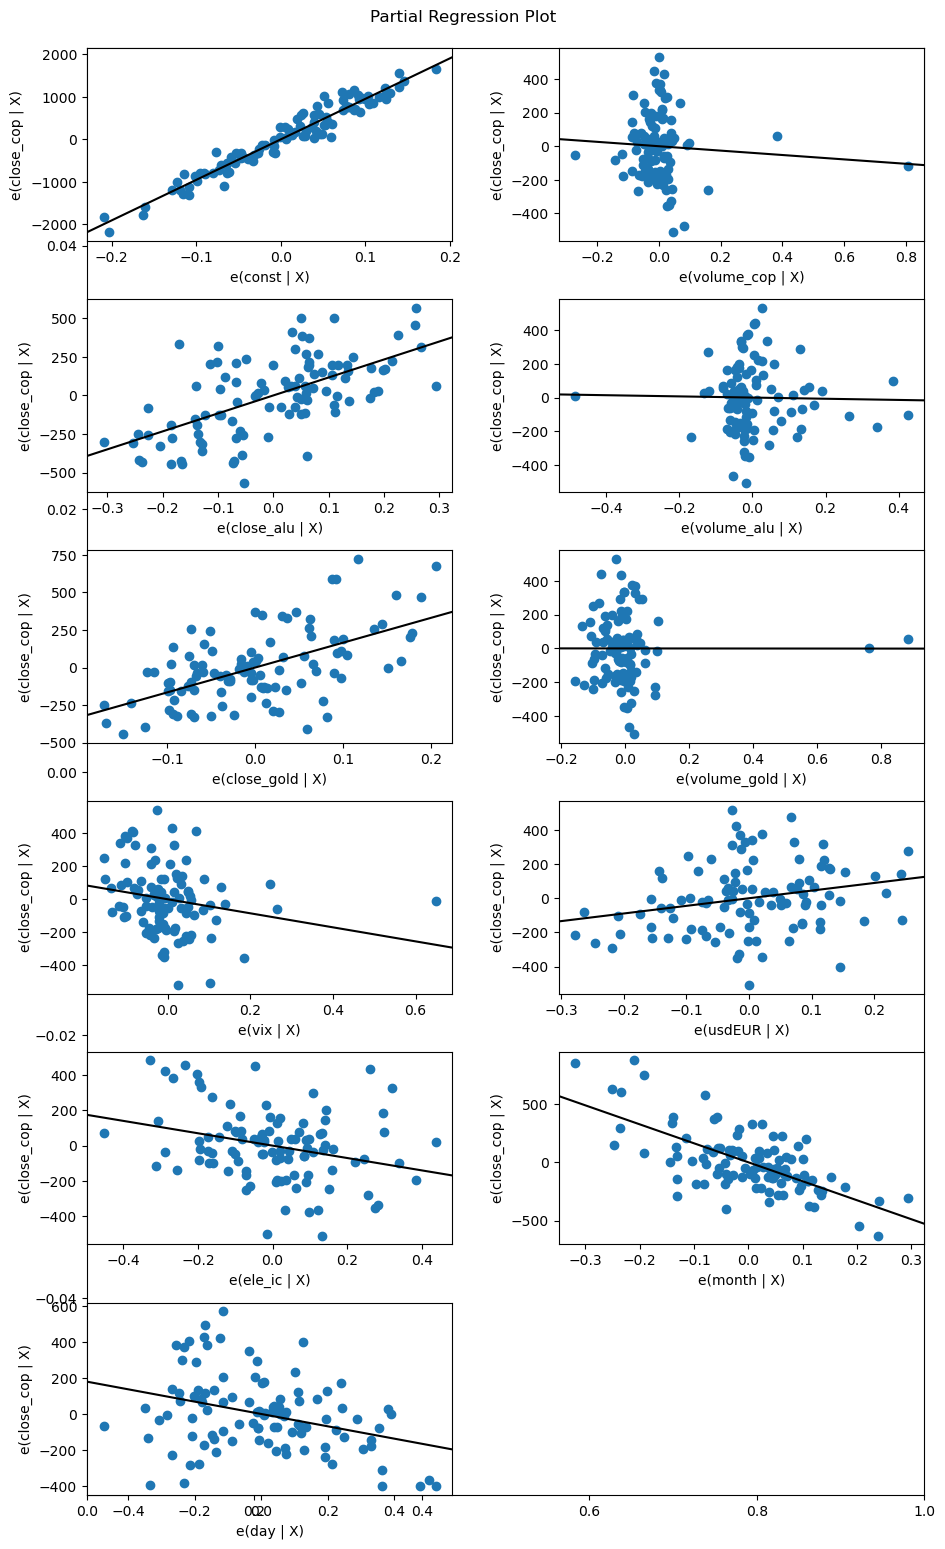

In [ ]:
# Residual Analysis

fig, ax = plt.subplots(figsize=(10,16))

fig = sm.graphics.plot_partregress_grid(regression_model, fig=fig)

for ax in fig.axes:
    ax.autoscale(enable=True, axis='y')

fig.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)

plt.show()

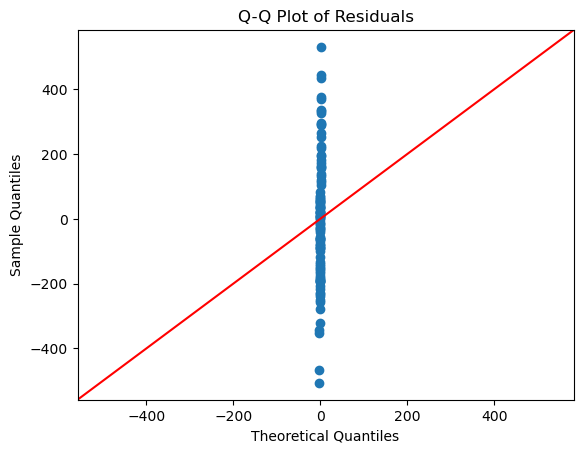

In [ ]:
# Q-Q plot
sm.qqplot(regression_model.resid, line='45')
plt.title("Q-Q Plot of Residuals")
plt.show()

In [ ]:
# Perform the BP test - Homoskedasticity

bp_test = het_breuschpagan(regression_model.resid, regression_model.model.exog)

bp_stat = bp_test[0]
bp_p_value = bp_test[1]

print("\nBreusch-Pagan test for heteroskedasticity:")
print(f"Test Statistic: {bp_stat:.4f}")
print(f"P-value: {bp_p_value:.4f}")

if bp_p_value < 0.05:
    print("Heteroskedasticity detected (reject null hypothesis).")
else:
    print("No significant heteroskedasticity detected (fail to reject null hypothesis).")


Breusch-Pagan test for heteroskedasticity:
Test Statistic: 36.0735
P-value: 0.0001
Heteroskedasticity detected (reject null hypothesis).


In [ ]:
# Perform the BG test for autocorrelation
bg_test = acorr_breusch_godfrey(regression_model, nlags=1)

print("\nBreusch-Godfrey test for autocorrelation:")
print(f"Test Statistic: {bg_test[0]:.4f}")
print(f"P-value: {bg_test[1]:.4f}")

if bg_test[1] < 0.05:
    print("Autocorrelation detected (reject null hypothesis).")
else:
    print("No significant autocorrelation detected (fail to reject null hypothesis).")


Breusch-Godfrey test for autocorrelation:
Test Statistic: 41.1615
P-value: 0.0000
Autocorrelation detected (reject null hypothesis).


In [ ]:
# Perform VIF for multicollinearity
variables = df_model[features]

vif_data = pd.DataFrame()
vif_data['Variable'] = variables.columns
vif_data['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]

vif_data

Variable          VIF
0   volume_cop     1.835063
1    close_alu   719.867843
2   volume_alu     1.427376
3   close_gold  2143.108260
4  volume_gold     1.582976
5          vix    38.308404
6       usdEUR   831.260190
7       ele_ic     1.626976
8        month    96.377837
9          day     6.191957

### 4.1.2 Influence Analysis

In [ ]:
influence = regression_model.get_influence()

influence_summary = influence.summary_frame()
influence_summary

dfb_const  dfb_volume_cop  dfb_close_alu  dfb_volume_alu  dfb_close_gold  \
0     0.205759       -0.197475      -0.117284        0.123846       -0.243766   
1    -0.189728       -0.115316       0.106040        0.046640       -0.186702   
2    -0.093507       -0.061177       0.069918        0.037703       -0.038688   
3     0.011107       -0.028286       0.010389        0.029701       -0.020030   
4    -0.033472       -0.020360       0.040688        0.020136        0.005216   
..         ...             ...            ...             ...             ...   
98    0.011271       -0.005075      -0.009339        0.013627       -0.032687   
99    0.018194       -0.006959      -0.012543        0.014925       -0.032547   
100   0.071977       -0.005667      -0.055378        0.014596       -0.078576   
101  -0.021252        0.004005       0.018303       -0.009398        0.046944   
102  -0.236891        0.035966       0.180665       -0.041490        0.209000   

     dfb_volume_gold   dfb_vix  dfb_usdEUR  dfb_ele_ic  dfb_month   dfb_day  \
0          -0.025853 -0.261686   -0.327970   -0.199015   0.094263  0.280640   
1          -0.061846 -0.070342    0.000075    0.024623   0.319645  0.428368   
2          -0.023516  0.012665    0.024541   -0.119499   0.122267  0.212647   
3           0.014172 -0.033603   -0.013432   -0.216979   0.051186  0.087297   
4           0.010273  0.003521    0.027265   -0.147172   0.050244  0.066133   
..               ...       ...         ...         ...        ...       ...   
98         -0.001250  0.002650   -0.009338    0.005095   0.001426  0.003435   
99          0.001921 -0.000191   -0.014964    0.004152  -0.002099 -0.006290   
100         0.003196 -0.023786   -0.072951    0.023911  -0.012280 -0.016584   
101        -0.001336  0.004074    0.019748   -0.013739  -0.007213  0.004770   
102         0.075630  0.083008    0.213168   -0.004442   0.058788  0.050005   

      cooks_d  standard_resid  hat_diag  dffits_internal  student_resid  \
0    0.052758       -2.367577  0.093819        -0.761802      -2.429861   
1    0.039585       -2.534708  0.063473        -0.659876      -2.613813   
2    0.015313       -1.607348  0.061209        -0.410423      -1.621519   
3    0.012353       -1.289143  0.075586        -0.368627      -1.293857   
4    0.006014       -0.951051  0.068150        -0.257196      -0.950552   
..        ...             ...       ...              ...            ...   
98   0.000529       -0.290049  0.064676        -0.076272      -0.288601   
99   0.000529       -0.274758  0.071552        -0.076275      -0.273373   
100  0.001781       -0.350518  0.137506        -0.139956      -0.348840   
101  0.000724        0.264823  0.101963         0.089234       0.263480   
102  0.014686        0.858524  0.179773         0.401928       0.857286   

       dffits  
0   -0.781843  
1   -0.680470  
2   -0.414041  
3   -0.369975  
4   -0.257061  
..        ...  
98  -0.075891  
99  -0.075891  
100 -0.139287  
101  0.088782  
102  0.401348  

[103 rows x 17 columns]

In [ ]:
# High leverage points
k = regression_model.df_model
n = regression_model.nobs
threshold = 3 * ((k + 1) / n)

influence_summary[influence_summary['hat_diag'] > threshold]

dfb_const  dfb_volume_cop  dfb_close_alu  dfb_volume_alu  dfb_close_gold  \
19  -0.003397       -0.002775       0.011862        0.003866       -0.002358   
38  -0.221237        0.662953       0.085760        0.648887       -0.010114   
60   0.071824        0.029291      -0.144267       -0.046861        0.002623   
65  -0.359483        0.173807       0.504690       -0.297465        0.111752   
82  -0.026937       -0.118933       0.011363        0.069425        0.002259   

    dfb_volume_gold   dfb_vix  dfb_usdEUR  dfb_ele_ic  dfb_month   dfb_day  \
19         0.035466  0.006120   -0.001475   -0.001323   0.001480  0.000288   
38        -0.088253 -0.029138    0.209296    0.136382   0.093779  0.099442   
60         0.432325 -0.095324   -0.020508    0.018652  -0.017371 -0.050566   
65        -0.163194  1.698592    0.275669   -0.297207  -0.150372  0.126636   
82        -0.007704 -0.001730    0.028829    0.015729   0.010501  0.017945   

     cooks_d  standard_resid  hat_diag  dffits_internal  student_resid  \
19  0.000165        0.042347  0.503623         0.042654       0.042116   
38  0.211385        0.997911  0.700148         1.524872       0.997888   
60  0.020783        0.414653  0.570745         0.478132       0.412780   
65  0.306522        1.829601  0.501809         1.836231       1.853666   
82  0.001539       -0.085237  0.699676        -0.130101      -0.084776   

      dffits  
19  0.042422  
38  1.524837  
60  0.475972  
65  1.860383  
82 -0.129398

In [ ]:
# Studentized Residuals
alpha = 0.05

Df = n - k - 1

t_critical = t.ppf(1 - alpha/2, Df)

influence_summary[abs(influence_summary['student_resid'])>t_critical ]

dfb_const  dfb_volume_cop  dfb_close_alu  dfb_volume_alu  dfb_close_gold  \
0    0.205759       -0.197475      -0.117284        0.123846       -0.243766   
1   -0.189728       -0.115316       0.106040        0.046640       -0.186702   
9    0.194772        0.038560      -0.167921        0.007493        0.244824   
12   0.185117        0.005289      -0.381839        0.072526        0.412002   
14  -0.227500       -0.040505       0.093656        0.014251        0.256652   

    dfb_volume_gold   dfb_vix  dfb_usdEUR  dfb_ele_ic  dfb_month   dfb_day  \
0         -0.025853 -0.261686   -0.327970   -0.199015   0.094263  0.280640   
1         -0.061846 -0.070342    0.000075    0.024623   0.319645  0.428368   
9         -0.020041  0.026428   -0.040527   -0.063170  -0.391007 -0.179662   
12        -0.061168 -0.079225   -0.074304    0.463030  -0.566886 -0.163286   
14        -0.145279  0.171655    0.150055    0.469443  -0.179560  0.150487   

     cooks_d  standard_resid  hat_diag  dffits_internal  student_resid  \
0   0.052758       -2.367577  0.093819        -0.761802      -2.429861   
1   0.039585       -2.534708  0.063473        -0.659876      -2.613813   
9   0.022436        2.158920  0.050287         0.496786       2.203702   
12  0.087630        2.731976  0.114378         0.981800       2.834497   
14  0.063994        2.285277  0.118778         0.839006       2.340216   

      dffits  
0  -0.781843  
1  -0.680470  
9   0.507091  
12  1.018644  
14  0.859176

In [ ]:
# Cook's Distance
cook_d_threshold = np.sqrt(k / n)

influence_summary[influence_summary['cooks_d'] > cook_d_threshold]

Empty DataFrame
Columns: [dfb_const, dfb_volume_cop, dfb_close_alu, dfb_volume_alu, dfb_close_gold, dfb_volume_gold, dfb_vix, dfb_usdEUR, dfb_ele_ic, dfb_month, dfb_day, cooks_d, standard_resid, hat_diag, dffits_internal, student_resid, dffits]
Index: []

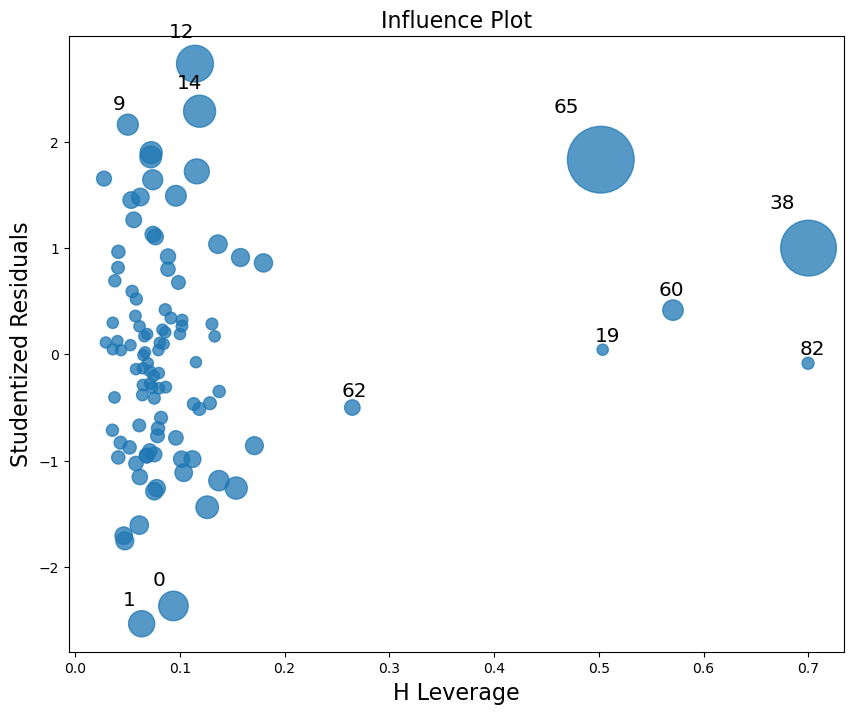

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
influence.plot_influence(ax=ax)

plt.show()

### 4.1.3 Cleaned model (excluding influential points based on studentized residuals)

In [ ]:
influential_points = influence_summary[abs(influence_summary['student_resid']) > t_critical]

train_data_cleaned = X_train_scaled_df_reset.drop(influential_points.index)
y_train_cleaned = y_train_reset.drop(influential_points.index)

regression_model_cleaned = sm.OLS(y_train_cleaned, train_data_cleaned).fit()

y_pred_cleaned = regression_model_cleaned.predict(X_test_scaled_df)

print(regression_model_cleaned.summary())

                            OLS Regression Results                            
Dep. Variable:              close_cop   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     107.0
Date:                Sun, 02 Feb 2025   Prob (F-statistic):           1.80e-44
Time:                        20:30:17   Log-Likelihood:                -639.20
No. Observations:                  98   AIC:                             1300.
Df Residuals:                      87   BIC:                             1329.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        9504.7024    212.046     44.824      

In [ ]:
rmse_cleaned = np.sqrt(mean_squared_error(y_test, y_pred_cleaned))

print(f"RMSE for the cleaned model: {rmse_cleaned:.4f}")

RMSE for the cleaned model: 444.8751


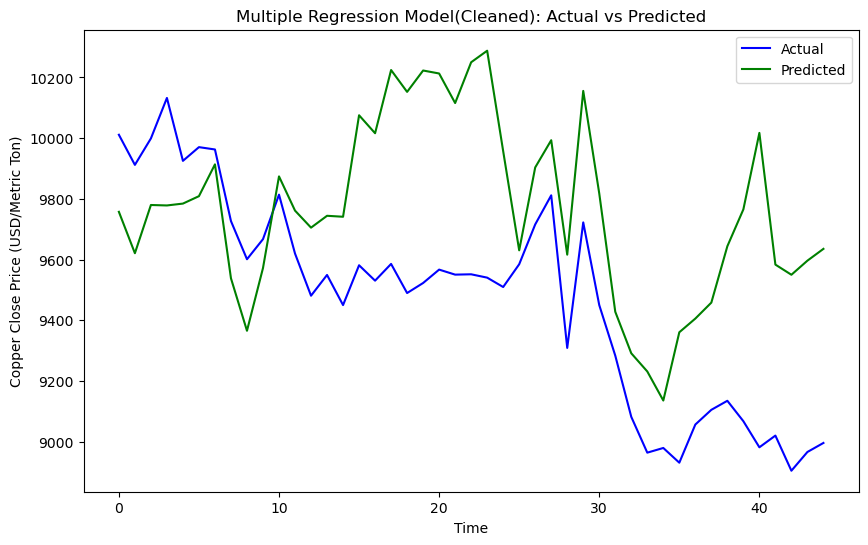

In [ ]:
y_test_reset = y_test.reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.plot(y_test_reset, label='Actual', color='blue')
plt.plot(y_pred_cleaned, label='Predicted', color='green')
plt.title('Multiple Regression Model(Cleaned): Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Copper Close Price (USD/Metric Ton)')
plt.legend()
plt.show()

## 4.2 XGBoost
---

In [ ]:
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

### Model 1: Hyperparameter tuning to identify optimal model

In [ ]:
xgb_model = xgb.XGBRegressor(random_state=42)

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
param_grid = {
    'n_estimators': [30, 40, 45, 50],
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 2, 3, 4],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
}


grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           cv=tscv,
                           scoring='r2',
                           n_jobs=-1,
                           verbose=1)

In [ ]:
grid_search.fit(X_train_scaled_df, y_train)

Fitting 5 folds for each of 12288 candidates, totalling 61440 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, imp...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 3, 4, 5],
                         'n_estimators': [30, 40, 45, 50],
                         'reg_alpha': [0, 0.1, 0.5, 1],
                         'reg_lambda': [1, 2, 3, 4],
                         'subsample': [0.6, 0.7, 0.8, 0.9]},
             scoring='r2', verbose=1)

In [ ]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 30, 'reg_alpha': 0.5, 'reg_lambda': 1, 'subsample': 0.7}


In [ ]:
y_train_pred = best_model.predict(X_train_scaled_df)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)


y_test_pred = best_model.predict(X_test_scaled_df)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)


train_adj_r2 = adjusted_r2(train_r2, len(X_train), X_train.shape[1])
test_adj_r2 = adjusted_r2(test_r2, len(X_test), X_test.shape[1])


print(f"Model Performance (Training Set)")
print(f"-------------------------------------")
print(f"Training MSE: {round(train_mse,3)}")
print(f"Training RMSE: {round(train_rmse,3)}")
print(f"Training R-squared: {round(train_r2,3)}")
print(f"Training Adjusted R-squared: {round(train_adj_r2,3)}")

print(f"\nModel Performance (Testing Set)")
print(f"-------------------------------------")
print(f"Testing MSE: {round(test_mse,3)}")
print(f"Testing RMSE: {round(test_rmse,3)}")
print(f"Testing R-squared: {round(test_r2,3)}")
print(f"Testing Adjusted R-squared: {round(test_adj_r2,3)}")


Model Performance (Training Set)
-------------------------------------
Training MSE: 267287.149
Training RMSE: 516.998
Training R-squared: 0.344
Training Adjusted R-squared: 0.272

Model Performance (Testing Set)
-------------------------------------
Testing MSE: 310714.565
Testing RMSE: 557.418
Testing R-squared: -1.634
Testing Adjusted R-squared: -2.409


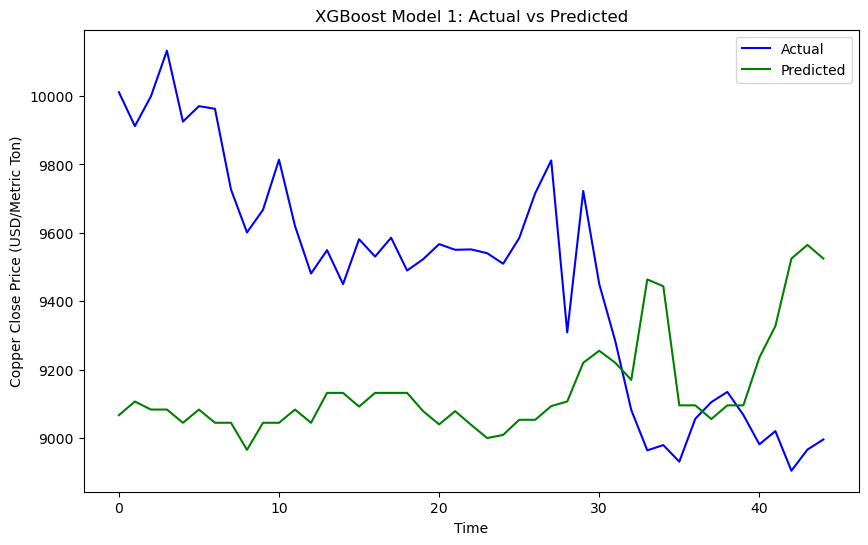

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_reset, label='Actual', color='blue')
plt.plot(y_test_pred, label='Predicted', color='green')
plt.title('XGBoost Model 1: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Copper Close Price (USD/Metric Ton)')
plt.legend()
plt.show()

### Model 2: No hyperparameter tuning

In [ ]:
xgb_model2 = xgb.XGBRegressor(random_state=42)

In [ ]:
xgb_model2.fit(X_train_scaled_df, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [ ]:
cross_scores = cross_val_score(xgb_model2, X_train_scaled_df, y_train, cv=tscv, scoring='r2')
print(f"Cross-Validation R-squared scores: {cross_scores}")
print(f"Average CV R-squared: {np.mean(cross_scores):.3f}")

Cross-Validation R-squared scores: [ -1.51568766  -3.97285153 -12.16734529  -5.81780681   0.75749674]
Average CV R-squared: -4.543


In [ ]:
y_train_pred = xgb_model2.predict(X_train_scaled_df)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)


y_test_pred = xgb_model2.predict(X_test_scaled_df)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)


train_adj_r2 = adjusted_r2(train_r2, len(X_train), X_train.shape[1])
test_adj_r2 = adjusted_r2(test_r2, len(X_test), X_test.shape[1])


print(f"Model Performance (Training Set)")
print(f"-------------------------------------")
print(f"Training MSE: {round(train_mse,3)}")
print(f"Training RMSE: {round(train_rmse,3)}")
print(f"Training R-squared: {round(train_r2,3)}")
print(f"Training Adjusted R-squared: {round(train_adj_r2,3)}")

print(f"\nModel Performance (Testing Set)")
print(f"-------------------------------------")
print(f"Testing MSE: {round(test_mse,3)}")
print(f"Testing RMSE: {round(test_rmse,3)}")
print(f"Testing R-squared: {round(test_r2,3)}")
print(f"Testing Adjusted R-squared: {round(test_adj_r2,3)}")

Model Performance (Training Set)
-------------------------------------
Training MSE: 0.0
Training RMSE: 0.009
Training R-squared: 1.0
Training Adjusted R-squared: 1.0

Model Performance (Testing Set)
-------------------------------------
Testing MSE: 347277.996
Testing RMSE: 589.303
Testing R-squared: -1.944
Testing Adjusted R-squared: -2.81


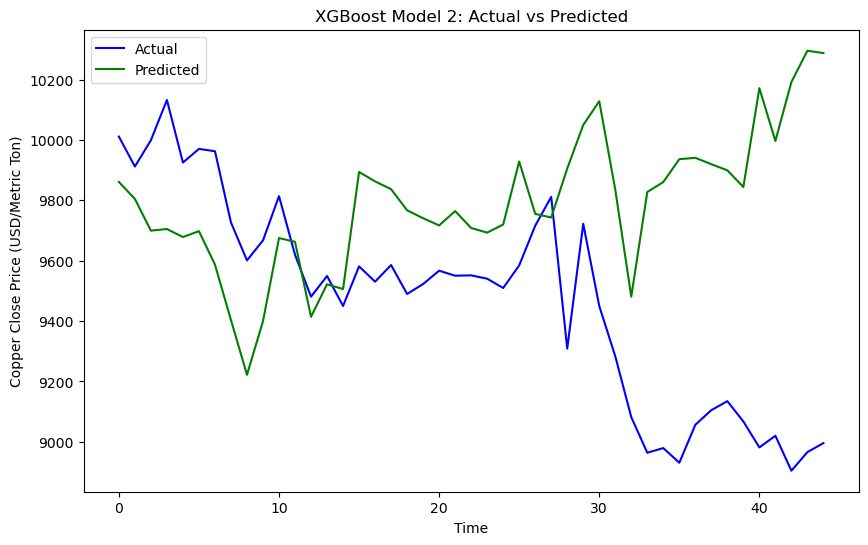

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_reset, label='Actual', color='blue')
plt.plot(y_test_pred, label='Predicted', color='green')
plt.title('XGBoost Model 2: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Copper Close Price (USD/Metric Ton)')
plt.legend()
plt.show()

### Model 3: Self-adjusted hyperparameters

In [ ]:
xgb_model3 = xgb.XGBRegressor(random_state=42,max_depth=4,reg_lambda =1,
                              n_estimators =30,reg_alpha =0.1,learning_rate =0.1,
                             colsample_bytree=0.6, subsample=0.7
                             )


In [ ]:
xgb_model3.fit(X_train_scaled_df, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=30, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [ ]:
cross_scores = cross_val_score(xgb_model3, X_train_scaled_df, y_train, cv=tscv, scoring='r2')
print(f"Cross-Validation R-squared scores: {cross_scores}")
print(f"Average CV R-squared: {np.mean(cross_scores):.3f}")


Cross-Validation R-squared scores: [-0.68043403 -0.71055808 -5.01283609  0.15588045 -0.8987103 ]
Average CV R-squared: -1.429


In [ ]:
y_train_pred = xgb_model3.predict(X_train_scaled_df)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)

y_test_pred = xgb_model3.predict(X_test_scaled_df)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)


train_adj_r2 = adjusted_r2(train_r2, len(X_train), X_train.shape[1])
test_adj_r2 = adjusted_r2(test_r2, len(X_test), X_test.shape[1])


print(f"Model Performance (Training Set)")
print(f"-------------------------------------")
print(f"Training MSE: {round(train_mse,3)}")
print(f"Training RMSE: {round(train_rmse,3)}")
print(f"Training R-squared: {round(train_r2,3)}")
print(f"Training Adjusted R-squared: {round(train_adj_r2,3)}")

print(f"\nModel Performance (Testing Set)")
print(f"-------------------------------------")
print(f"Testing MSE: {round(test_mse,3)}")
print(f"Testing RMSE: {round(test_rmse,3)}")
print(f"Testing R-squared: {round(test_r2,3)}")
print(f"Testing Adjusted R-squared: {round(test_adj_r2,3)}")


Model Performance (Training Set)
-------------------------------------
Training MSE: 265329.11
Training RMSE: 515.101
Training R-squared: 0.349
Training Adjusted R-squared: 0.278

Model Performance (Testing Set)
-------------------------------------
Testing MSE: 288188.541
Testing RMSE: 536.832
Testing R-squared: -1.443
Testing Adjusted R-squared: -2.162


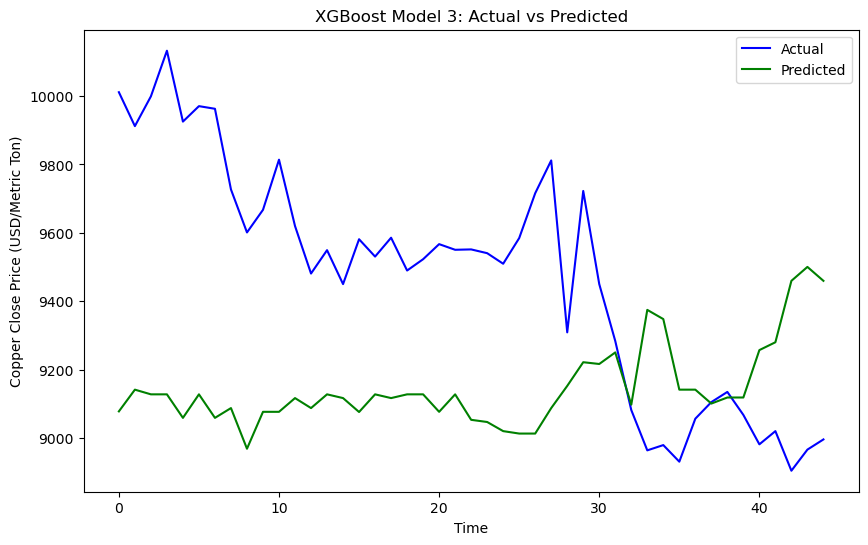

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_reset, label='Actual', color='blue')
plt.plot(y_test_pred, label='Predicted', color='green')
plt.title('XGBoost Model 3: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Copper Close Price (USD/Metric Ton)')
plt.legend()
plt.show()

In [ ]:
# Important features
feature_importance_list = sorted(zip(xgb_model3.feature_importances_, X.columns), reverse=True)

for importance, feature_name in feature_importance_list[:5]:
    print(f"Feature: {feature_name}, Importance: {importance}")

Feature: volume_alu, Importance: 0.3285328149795532
Feature: day, Importance: 0.26896873116493225
Feature: usdEUR, Importance: 0.24105285108089447
Feature: volume_gold, Importance: 0.06333712488412857
Feature: close_gold, Importance: 0.05797864496707916


### 4.3 LSTM Model

In [23]:
# Feature selection (Consistent with "2. Data Processing")
features = ['volume_cop','close_alu','volume_alu','close_gold','volume_gold',
       'vix', 'usdEUR','ele_ic','month', 'day']

X = df_model[features]
y = df_model["close_cop"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle= False)

In [24]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))


In [25]:
train_data_scaled = np.hstack((X_train_scaled, y_train_scaled))
test_data_scaled = np.hstack((X_test_scaled, y_test_scaled))

In [26]:
timesteps = 10

def create_dataset(data, timesteps=10):
    X, y = [], []
    for i in range(timesteps, len(data)):
        X.append(data[i-timesteps:i, :-1])
        y.append(data[i, -1])
    return np.array(X), np.array(y)

In [27]:
X_train_lstm, y_train_lstm = create_dataset(train_data_scaled, timesteps)
X_test_lstm, y_test_lstm = create_dataset(test_data_scaled, timesteps)

In [28]:
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], X_train_lstm.shape[2]))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], X_test_lstm.shape[2]))


In [29]:
def build_lstm_model(hp):
    model = Sequential()
    units = hp.Int('units', min_value=50, max_value=200, step=50)
    model.add(Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(LSTM(units=units, return_sequences=True))
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

tuner = kt.Hyperband(
    build_lstm_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='keras_tuner_dir',
    project_name='lstm_tuning'
)

In [30]:
tuner.search(X_train_lstm, y_train_lstm, epochs=20, validation_data=(X_test_lstm, y_test_lstm), batch_size=32)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Units: {best_hps.get('units')}")
print(f"Best Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Best Optimizer: {best_hps.get('optimizer')}")


Trial 30 Complete [00h 00m 09s]
val_loss: 0.025346552953124046

Best val_loss So Far: 0.017840983346104622
Total elapsed time: 00h 03m 24s
Best Units: 50
Best Dropout Rate: 0.4
Best Optimizer: rmsprop


In [31]:
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=50,
    validation_data=(X_test_lstm, y_test_lstm),
    batch_size=32
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - loss: 0.1291 - val_loss: 0.0235
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0430 - val_loss: 0.0380
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0297 - val_loss: 0.0429
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0327 - val_loss: 0.0360
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0315 - val_loss: 0.0522
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0257 - val_loss: 0.0391
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0269 - val_loss: 0.0389
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0204 - val_loss: 0.0382
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0211 - val_loss: 0.0239
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0170 - val_loss: 0.0626
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0205 - val_loss: 0.0311
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0192 - val_loss: 0.0830


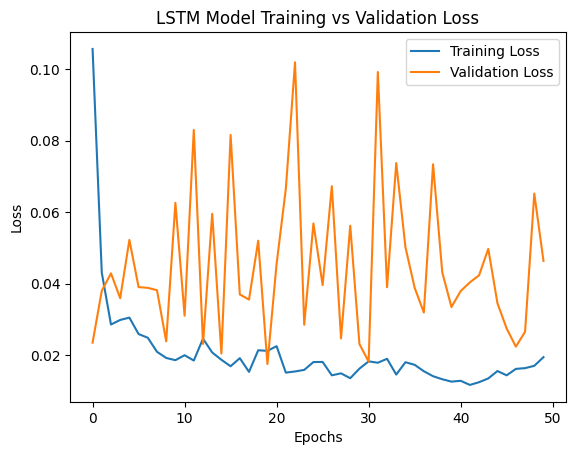

In [32]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
test_loss = best_model.evaluate(X_test_lstm, y_test_lstm)
print(f"Final Test Loss: {test_loss}")

train_loss = best_model.evaluate(X_train_lstm, y_train_lstm)
print(f"Final Train Loss: {train_loss}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0405
Final Test Loss: 0.0463700033724308
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0110 
Final Train Loss: 0.009017235599458218


In [34]:
y_pred_lstm = best_model.predict(X_test_lstm)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


In [35]:
y_pred_lstm_rescaled = scaler_y.inverse_transform(y_pred_lstm)
y_test_lstm_rescaled = scaler_y.inverse_transform(y_test_lstm.reshape(-1, 1))

In [36]:
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm_rescaled, y_pred_lstm_rescaled))
print(f'LSTM Model RMSE: {rmse_lstm:.4f}')


LSTM Model RMSE: 560.9007


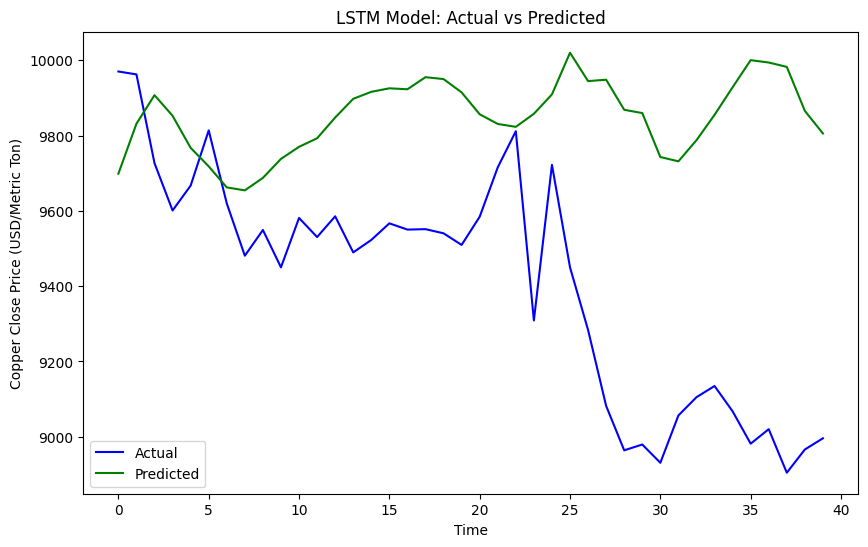

In [37]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_lstm_rescaled, label='Actual', color='blue')
plt.plot(y_pred_lstm_rescaled, label='Predicted', color='green')
plt.title('LSTM Model: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Copper Close Price (USD/Metric Ton)')
plt.legend()
plt.show()